# Tutorial: Diffusion Map Embedding & Label Transfer with **acdc_py**

A **diffusion map** is a powerful nonlinear dimensionality reduction technique, particularly useful for capturing intrinsic structures in single-cell data. It's often used for visualization and pre-processing, especially when analyzing dynamic biological processes or subtle differences between cell states.

In many applications, we may have **reference single-cell data**—for example, from healthy tissue—and want to compare it to **query data**, such as cells from a diseased condition. A key question is: *how similar are the query cells to the reference cells in various embedding spaces, such as PCA, UMAP, or diffusion maps?*

Once both datasets are aligned in a common space, we can perform **label transfer**, propagating known annotations (e.g. cell types) from the reference to the query data. While **Scanpy’s `ingest`** function supports mapping and label transfer in PCA/UMAP space, it does not support **diffusion maps**, and its all-in-one design makes it hard to control mapping and label transfer independently.

**AC/DC** addresses these limitations by providing:
- `acdc_py.run_diffusion_map`: a flexible diffusion map implementation with support for **Nyström extension** (query mapping)
- `acdc_py.transfer_labels_anndata`: a modular, standalone **label transfer method** that can operate in any space, including the mapped diffusion space or PCA.

Both methods work with reference and query AnnData objects.

---

## In this hands-on tutorial, we’ll explore how to:

1. **Compute diffusion map embeddings** on single-cell gene expression data  
2. **Project new (query) cells** into that diffusion space via the Nyström extension  
3. **Transfer cell-type labels** from a reference set to held-out query cells using K-nearest-neighbors  

We’ll walk through:

- Loading and preprocessing a public single-cell dataset  
- Building and visualizing a diffusion map  
- Splitting the data into reference/query subsets  
- Projecting query cells into the diffusion space  
- Running KNN-based label transfer and evaluating accuracy  

---

**Prerequisites:**  
- An environment with `acdc_py` installed  

Let’s get started!


## 1. Suppress Warnings
To keep output clean, we’ll hide non‑critical Python warnings that might clutter the notebook.

In [1]:
import warnings
# Hide non-critical warnings for a cleaner notebook output
warnings.filterwarnings("ignore")

## 2. Import Required Libraries
We’ll load standard data‑science packages, Scanpy for single‑cell analysis, our `acdc_py` toolkit, and a utility to split data into training and test sets.

In [2]:
import pandas as pd      # DataFrame operations
import scanpy as sc      # Single‑cell analysis framework
import acdc_py as acdc   # Our diffusion map & label‑transfer toolkit
from sklearn.model_selection import train_test_split  # Train/test splitting

## 3. Load Gene Expression Data
Fetch a preprocessed single‑cell counts table from GitHub and wrap it in an AnnData object.


In [3]:
# Base URL for the example dataset
data_folder = 'https://raw.githubusercontent.com/califano-lab/acdc_py_data/main/'

# Read cell×gene count matrix
gex_df = pd.read_parquet(data_folder + 'TE001_counts.parquet.gzip')

# Create Scanpy AnnData
adata = sc.AnnData(gex_df)

## 4. Basic Preprocessing  
Filter lowly‑expressed genes, normalize counts, log‑transform, and scale features.


In [4]:
# Remove genes expressed in fewer than 3 cells
sc.pp.filter_genes(adata, min_cells=3)

# Normalize each cell to total count = 1e4, then log1p
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Scale to unit variance and clip extreme values at ±10
sc.pp.scale(adata, max_value=10)


## 5. Select Highly Variable Genes  
To focus on informative features, we’ll keep the top 2,000 most variable genes.


In [5]:
# Identify and subset to the 2,000 most variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=True
)

## 6. Build Neighborhood Graph & UMAP  
Compute PCA, construct the k‑NN graph, detect clusters with Leiden (since they aren't available in the raw data), and visualize with UMAP.

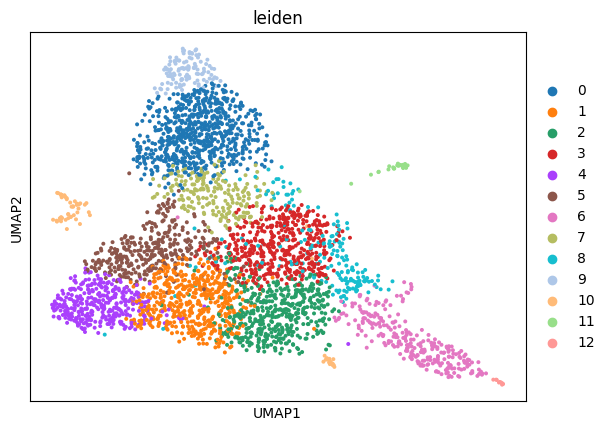

In [6]:
# Dimensionality reduction via PCA
sc.pp.pca(adata)

# Build k-NN graph on PCs
sc.pp.neighbors(adata)

# Cluster cells (Leiden algorithm) and compute 2D UMAP
sc.tl.leiden(adata)
sc.tl.umap(adata)

# Plot UMAP colored by Leiden cluster
sc.pl.umap(adata, color="leiden")

## 7. Create Reference & Query Splits  

In a real-world use case scenario, you would have some reference data - usually more abundant - in input and some query data. Here, for simplicity, we split one dataset into reference and query by randomly choosing observations for either group. We use a 80% reference 20% query split; feel free to experiment with different percentages!

In [7]:
# Split indices into 80% reference / 20% query
ref_indices, query_indices = train_test_split(
    range(adata.n_obs), test_size=0.2, random_state=42
)

ref_adata = adata[ref_indices].copy()
query_adata = adata[query_indices].copy()

# Preserve true labels in query for later accuracy assessment
query_adata.obs["true_leiden"] = query_adata.obs["leiden"].copy()
del query_adata.obs["leiden"]

# Display query AnnData summary
query_adata


AnnData object with n_obs × n_vars = 732 × 2000
    obs: 'true_leiden'
    var: 'n_cells', 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## 8. Compute Diffusion Map & Nyström Extension

In this step, we compute a **diffusion map embedding** on the reference dataset, and then **project the held-out query cells** into the same diffusion space using the **Nyström extension** method. This enables consistent visualization and downstream analysis of both datasets in a shared low-dimensional space.

The `acdc.run_diffusion_map()` function offers several tunable parameters:

- **`embedding_key="X"`**  
  Specifies the input representation used to compute the diffusion map.  
  Use `"X"` to apply the method directly to `.X`, or provide the name of a custom representation stored in `.obsm`.

- **`neigen=10`**  
  Number of diffusion components (dimensions) to compute. These serve as the coordinates in the resulting diffusion space.

- **`pca_comps=None`**  
  *(Optional)* Number of principal components to use for preprocessing before constructing the diffusion map.  
  Reducing dimensionality via PCA can significantly speed up computation, at the potential cost of minor loss in mapping accuracy.

- **`k=None`**  
  *(Optional)* Number of nearest neighbors to consider when building the affinity matrix.  
  If provided, a sparse k-NN graph is used instead of the full pairwise distance matrix. This can speed up computation on larger datasets and may affect the resolution of the resulting diffusion space.

> **Note:** You can visualize the reference and query cells together in the resulting diffusion space by setting `plot=True`.

Computing diffusion map (10 components) on reference...
Extending to query via Nyström extension...


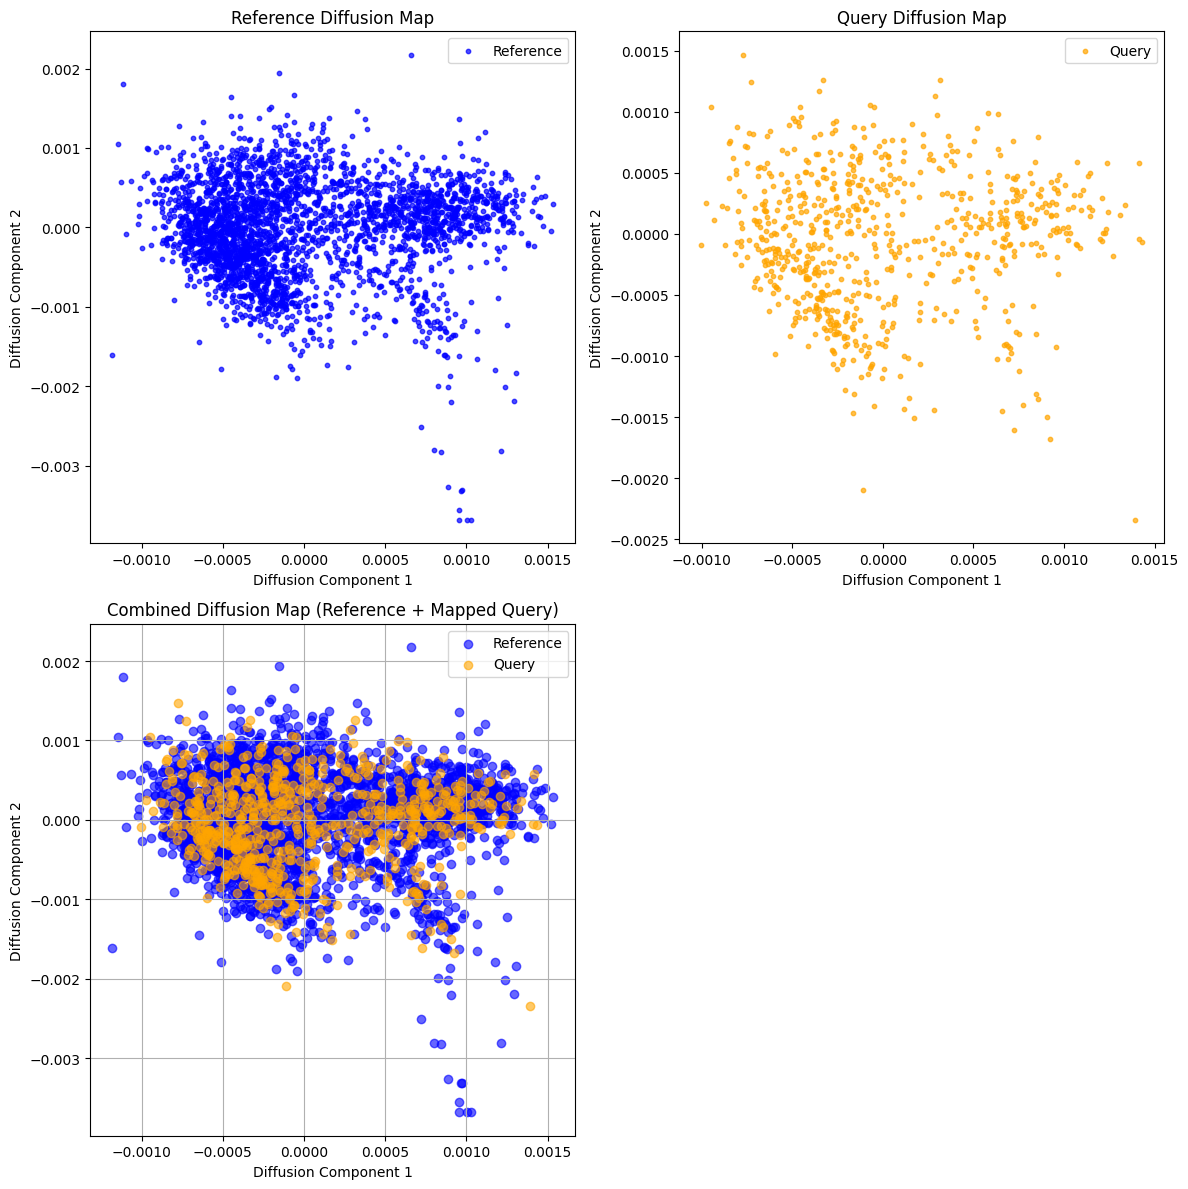

Stored embeddings in .obsm['X_diffmap'] and details in .uns['diffusion_results'].


In [8]:
acdc.run_diffusion_map(
    ref_adata, # Reference AnnData    
    query_adata, # Query AnnData
    embedding_key="X", # Input reference representation to the diffusion map dimensionality reduction 
    neigen=10, # Number of output dimensions in diffusion space         
    pca_comps=None, # Number of PCA components to apply to input data before running diffusion map     
    k=None, # Number of neighbors to use in the diffusion map graph affinity matrix            
    plot=True # Whether to plot the reference+mapped query 2D diffusion coordinates or not          
)

### Interpreting the Diffusion Map Plot

Here, we visualize the first two diffusion components, showing reference and query cells separately (first row) and in the same low-dimensional space (second row). This allows us to inspect how well the query cells were mapped to the reference structure.

However, this is only the **first step** in evaluating mapping quality. The **next step** is to check whether the transferred labels on the query match their original (ground truth) labels — providing a more objective measure of alignment accuracy.


## 9. Transfer Labels from Reference to Query

Once the query cells have been mapped into a common embedding space (e.g. diffusion map or PCA), we can transfer labels from the reference dataset using a **K-nearest neighbors classifier**.

The `acdc.transfer_labels_anndata()` function performs this label transfer and optionally evaluates prediction accuracy if ground-truth labels are available.

### Key Parameters:

- **`embedding_key="X_diffmap"`**  
  Specifies the space in which to perform KNN label transfer.  
  Must match the key in `.obsm` where the shared embedding (e.g., PCA or diffusion map) is stored.  
  In this case, we use the **diffusion map** coordinates stored under `'X_diffmap'`.

- **`pca_comps=None`**  
  *(Optional)* Number of PCA components to compute before label transfer. If a number is provided, PCA will be computed de novo on the reference using specified components and query cells will be mapped onto the reference using the PCA loadings (components) before running label transfer. If left as `None`, existing embeddings (e.g., from diffusion mapping) are used as-is. Notice that this argument is only relevant if the embedding key is set on X_pca.

- **`label_key="leiden"`**  
  The key in `ref_adata.obs` that contains the labels to transfer (e.g., cell clusters or types).

- **`n_neighbors=15`**  
  The number of neighbors used in the KNN classifier.

- **`ground_truth_label="true_leiden"`**  
  *(Optional)* If provided, the accuracy of transferred labels is computed by comparing them to known labels in `query_adata.obs[ground_truth_label]`.

- **`plot_labels=True`**  
  Visualizes the predicted vs. ground-truth labels using the selected embedding.

> **Tip:** This function is modular and works with **any shared embedding** (e.g., PCA, diffusion map, or UMAP), giving you full control over when and how mapping and label transfer


Labels transferred to query .obs['leiden'] using X_diffmap embedding.
Accuracy against 'true_leiden': 0.84


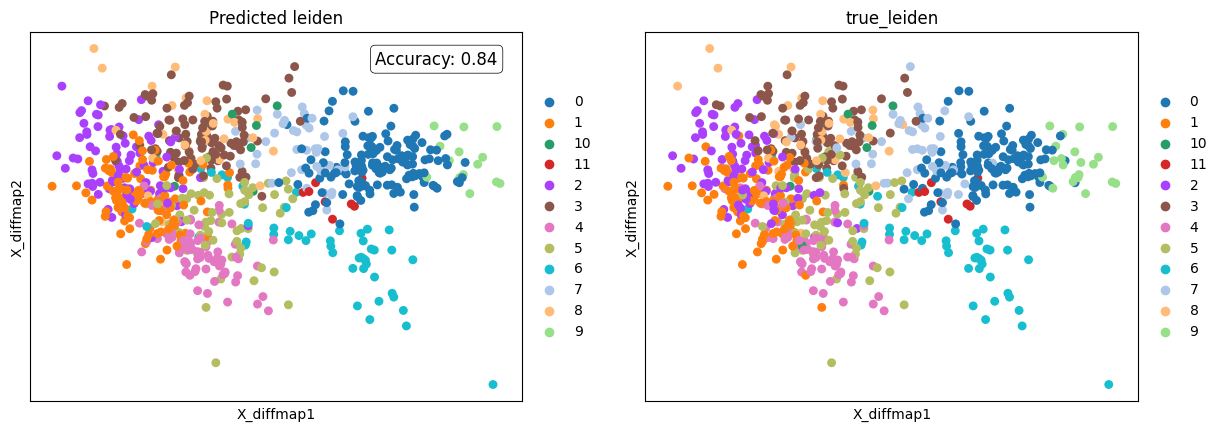

In [9]:
acdc.transfer_labels_anndata(
    ref_adata=ref_adata, # Reference AnnData            
    query_adata=query_adata, # Query AnnData
    embedding_key='X_diffmap', # Use X_diffmap to run query to ref mapping. Alternatively, use X_pca to run query to ref mapping using PCA   
    pca_comps=None, # Use with embedding_key='X_pca' to run query to ref mapping using PCA                 
    label_key='leiden', # Label key in reference AnnData              
    n_neighbors=15, # k in k-NN classifier. Determines the resolution of the label transfer.                
    ground_truth_label="true_leiden", # If ground truth available, it will be used to assess label transfer accuracy
    plot_labels=True # Plot ground truth and predicted labels of the query if ground truth is available              
)

### Interpreting the Previous Plot

We can assess the quality of the query-to-reference mapping in two ways:

- **Qualitatively**, by visually comparing the predicted labels (transferred from the reference) with the ground truth labels on the UMAP plot.
- **Quantitatively**, by reviewing the printed accuracy score.

In this example, label transfer was performed in the **diffusion map space**, resulting in an **accuracy of 84%**. This means that out of every 100 query cells, 84 were assigned the correct cluster label based on their position in the mapped space.
